In [1]:
%load_ext tikzmagic
%matplotlib inline

# 과최적화와 정규화

회귀분석을 하는 1차 목적은 종속변수와 독립변수의 관계를 알아내는 것이지만 2차 목적은 독립변수 데이터를 이용하여 종속변수를 예측하는 것이다. 그런데 이미 종속변수 값을 알고 있는 경우는 사실 예측을 할 필요가 없다. 종속변수 값 예측이 필요한 경우는 독립변수만 알고 있고 종속변수를 모르는 경우다. 보스턴 집값 데이터를 예로 들자면 보스턴에 새로운 지역이 생겨서 방의 평균 개수 등 독립변수 값은 알고 있지만 집값이라는 종속변수 값을 모를 때 이를 대강이라도 예측하기 위한 것이다. 따라서 이미 회귀분석에 사용된 데이터를 예측하는 것보다 중요한 것이 회귀분석에 사용되지 않은 데이터에 대해 예측을 잘 할 수 있어야 한다.

예측식을 구하기 위해 이미 회귀분석에 사용된 데이터를 <b>학습 데이터(traing data)</b>라 하고 이 데이터의 예측 성능을 <b>표본내(in-sample) 예측 성능</b> 또는 <b>학습성능</b>이라 한다. 올바른 예측 성능을 구하려면 회귀분석에 사용되지 않은 데이터에 대해서도 예측을 잘 할 수 있는지를 검증해야 한다. 회귀분석에 사용되지 않았지만 종속변수 값을 가지고 있어 예측 성능을 검증하는데 쓰일 수 있는 데이터를 <b>검증 데이터(test data)</b>라 하고 이를 이용한 예측 성능을 <b>표본외(out-of-sample) 예측 성능</b> 또는 <b>검증성능</b>이라고 한다. 예측이 회귀분석의 주된 목표라면 중요한 것은 표본내 예측 성능이 아니라 분석에 사용되지 않은 별개의 새로운 데이터를 넣었을 때 얼마나 예측을 잘 하는지를 알려주는 표본외 예측 성능이다. 표본외 성능을 계산할 때는 가지고 있는 데이터를 두 개로 나누어 하나를 학습 데이터로 사용한 회귀분석을 하고 나머지 데이터를 검증 데이터로 사용하여 표본외 성능을 알아보는 것이 일반적이다. 이러한 방법을 <b>교차검증(cross-validation)</b>이라고 한다. 

이 때 학습 데이터를 이용한 표본내 성능을 높이기 위해 독립변수의 수를 너무 많이 늘리거나 너무 복잡한 비선형 모형을 사용하게 되면 표본내 성능은 높아지지만 표본외 성능이 하락하는 <b>과최적화(over-fitting)</b> 현상이 발생할 수 있다. 따라서 회귀분석을 할 때는 교차검증을 통해 과최적화가 발생하지 않도록 해야 한다. 

이 절에서는 보스턴 집값 데이터를 사용하여 과최적화가 발생하는 현상을 살펴보고 이를 막기 위해 어떠한 조치를 취해야하는지를 설명한다.

## 과최적화

우선 교차검증을 위해 보스턴 집값 데이터를 100개의 학습 데이터와 나머지 검증 데이터로 분리한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston_train = boston.iloc[:100]
boston_test = boston.iloc[100:]

lstat 값을 독립변수로 사용하는 간단한 회귀분석을 한 결과는 다음과 같다.

In [3]:
x_name = "lstat"
formula = f"medv ~ scale({x_name})"
result1 = sm.OLS.from_formula(formula, boston_train).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     121.4
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           7.54e-19
Time:                        16:43:45   Log-Likelihood:                -279.06
No. Observations:                 100   AIC:                             562.1
Df Residuals:                      98   BIC:                             567.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.3090      0.398     56.027   

이제 이 회귀분석의 표본내 성능을 늘리기 위해 앞 절에서 설명한 다항회귀를 실시한다. 다음은 다항회귀의 차수를 10차까지 늘리면서 회귀분석을 반복 실시하는 코드다.

In [4]:
N = 10

results = {1: result1}
for i in range(2, N + 1):
    formula += f" + scale(I({x_name} ** {i}))"
    result_i = sm.OLS.from_formula(formula, boston_train).fit()
    results[i] = result_i

이렇게 다항회귀의 차수를 늘렸을 때 표본내 성능을 결정계수 $R^2$와 잔차제곱합 RSS로 살펴보면 다음과 같이 차수를 늘림에 따라 결정계수가 계속 증가하고 잔차제곱합이 계속 감소하는 것을 알 수 있다. 

In [5]:
df_rss = pd.DataFrame.from_records(
    [(i, r.rsquared, r.ssr) for i, r in results.items()],
    columns=["차수", "학습 결정계수", "학습 잔차제곱합"]
).set_index("차수")

df_rss.style.bar()

,학습 결정계수,학습 잔차제곱합
차수,,
1,0.553373,1553.790601
2,0.686105,1092.022691
3,0.710969,1005.522571
4,0.723554,961.739072
5,0.723823,960.802511
6,0.728595,944.200845
7,0.729950,939.488687
8,0.740790,901.775330
9,0.743152,893.559046


결정계수와 잔차제곱합이 변하는 모습은 다음 그림과 같다. 이 결과만 보면 마치 차수가 가장 높은 10차 다항회귀모형을 선택하는 것이 옳은 결정인 것 처럼 보인다.

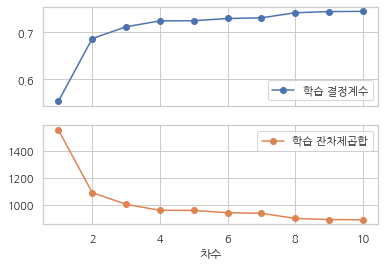

In [6]:
df_rss.plot(y=["학습 결정계수", "학습 잔차제곱합"], marker="o", subplots=True)
plt.show()

다음은 과최적화가 발생하는지 살펴보기 위해 학습 데이터와 예측 결과를 시각화하여 표시한 것이다. 차수가 증가함에 따라 예측식의 모양이 복잡해지면서 학습에 사용된 데이터는 더 잘 예측하지만 학습에 사용되지 않은 lstat 값에 대해서는  상식적으로 나올 수 없는 값을 예측하는 것을 볼 수 있다.

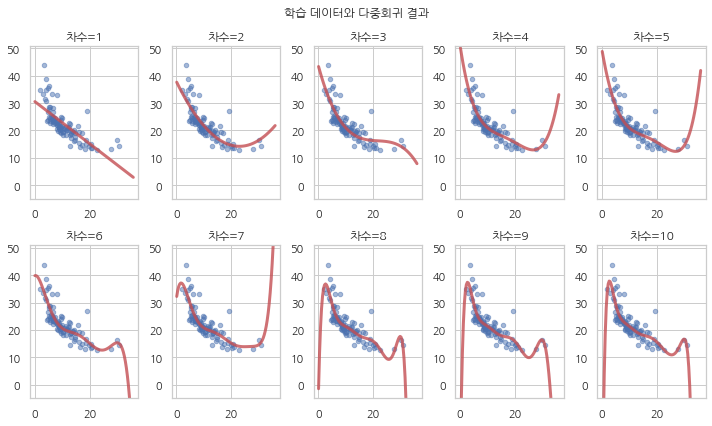

In [7]:
import pandas as pd

def plot_train(results, i, subplot):
    r_i = results[i]
    x = pd.DataFrame({x_name: np.linspace(0.1, 35.9, 100)})
    y = r_i.predict(x)

    plt.subplot(*subplot)
    plt.scatter(boston_train[x_name], boston_train["medv"], marker='o', s=20, alpha=0.5)
    plt.plot(x[x_name].values, y.values, lw=3, alpha=0.8, c="r")
    plt.ylim(-5, 51)
    plt.title(f"차수={i}")

plt.figure(figsize=(10, 6))
for i in range(1, 11):
    plot_train(results, i, [2, 5, i])
plt.suptitle("학습 데이터와 다중회귀 결과")
plt.tight_layout()
plt.show()

예를 들어 10차 다항회귀모형은 lstat 값이 34.5 일 때 집값을 -216.9 라고 예측한다. 

In [8]:
result10 = results[10]
result10.get_prediction(pd.DataFrame({"lstat": [34.5]})).predicted_mean

array([-216.93650211])

하지만 검증 데이터에서 lstat 값이 33~35 사이인 데이터를 찾아보면 실제로는 집값이 8.4 ~ 17.9 범위인 것을 알 수 있다.

In [9]:
boston_test[(boston_test.lstat > 34) & (boston_test.lstat < 35)][["lstat", "medv"]]

,lstat,medv
141,34.41,14.4
373,34.77,13.8
412,34.37,17.9
438,34.02,8.4


다음은 학습에 사용하지 않은 검증 데이터와 예측식을 비교한 그림이다. 차수가 증가하면서 실제 집값과는 동떨어진 값을 예측하고 있음을 알 수 있다.

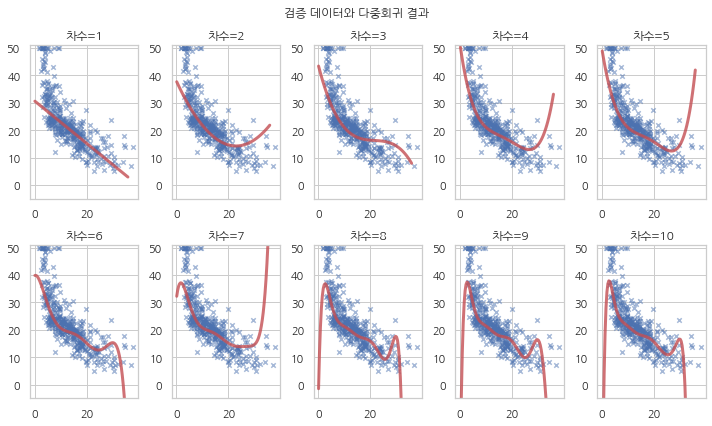

In [10]:
def plot_test(results, i, subplot):
    r_i = results[i]
    x = pd.DataFrame({x_name: np.linspace(0.1, 35.9, 100)})
    y = r_i.predict(x)

    plt.subplot(*subplot)
    plt.scatter(boston_test[x_name], boston_test["medv"], marker='x', s=20, alpha=0.5)
    plt.plot(x[x_name].values, y.values, lw=3, alpha=0.8, c="r")
    plt.ylim(-5, 51)
    plt.title(f"차수={i}")

plt.figure(figsize=(10, 6))
for i in range(1, 11):
    plot_test(results, i, [2, 5, i])
plt.suptitle("검증 데이터와 다중회귀 결과")
plt.tight_layout()
plt.show()

검증 데이터에 대한 잔차제곱합을 구해보면 다음과 같다.

In [11]:
rss_test = []
for i, r in results.items():
    y_true = boston_test.medv
    y_pred = r.get_prediction(boston_test).predicted_mean
    rss_test.append(((y_true - y_pred) ** 2).sum())

df_rss["검증 잔차제곱합"] = rss_test
df_rss[["검증 잔차제곱합"]].style.bar()

,검증 잔차제곱합
차수,
1,20145.399074
2,17656.438628
3,16362.769041
4,18075.527274
5,21171.613313
6,32154.412838
7,49392.894713
8,5070235.057569
9,44132.795197


차수가 3차까지 증가할 때는 잔차제곱합이 감소하지만 그 이후에는 오히려 잔차제곱합이 증가하여 예측 오차가 커지는 것을 알 수 있다. 이러한 현상을 과최적화라고 부른다. 과최적화를 막으려면 회귀분석을 할 때 표본내 성능을 사용하지 말고 표본외 성능을 이용해야 한다. 따라서 다항회귀의 차수는 가장 표본내 성능이 좋은 8차 모형이 아니라 가장 표본외 성능이 좋은  3차 모형을 사용해야 한다.

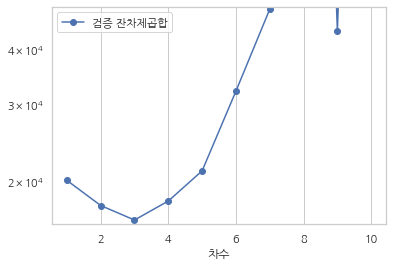

In [12]:
df_rss.plot(y=["검증 잔차제곱합"], logy=True, marker="o")
plt.ylim(1.6e4, 5e4)
plt.show()

## 조정 성능 지표

모형선택에 대한 절에서 설명하였듯이 선형회귀분석의 결정계수 값은 독립변수의 수가 증가할수록 항상 증가한다. 따라서 교차검증이 없이 학습 데이터를 사용한 결정계수만 고려하면 과최적화가 될 수 있다. 이를 피하기 위해 선형회귀분석에서는 다음과 같은 여러가지 대체 성능 지표를 제공한다. 이러한 대체 성능 지표는 모두 독립변수의 수가 증가하면 이에 따른 벌점(penalty)을 지표에 넣어 성능을 감소시킨다.

* 조정결정계수 (Adjusted R-Squared, Adjusted coefficient of determination)
* AIC (Akaike information criterion)
* BIC (Bayesian information criterion)


조정결정계수는 $R^2_{\text{adj}}$ 로 표기하며 다음과 같이 정의한다.

$$
R^2_{\text{adj}} = 1 - (1 - R^2)\dfrac{N-1}{N-K} = 1 - \dfrac{\text{RSS}/(N-K)}{\text{TSS} /(N-1)}
$$

조정결정계수 $R^2_{\text{adj}}$는 항상 결정계수 $R^2$보다 같거나 작으며 독립변수의 수 $K$가 증가할수록 그 차이가 커진다.

AIC(Akaike information criterion)와 BIC(Bayesian information criterion)는 로그가능도(log-likelihood) 값에 독립변수의 수로 인한 벌점을 추가한 것이며 각각 다음과 같이 정의한다.

$$
\text{AIC} = N + N \log(2\pi) + N \log \left( \dfrac{RSS}{N} \right) + 2K
$$

$$
\text{BIC} = N + N \log(2\pi) + N \log \left( \dfrac{RSS}{N} \right) + K\log N
$$

AIC나 BIC는 값이 작을수록 회귀성능이 좋다고 판단한다.

이 값들은 선형회귀분석 결과 요약의 상단 오른쪽에 나타나고 각각 회귀분석 결과 객체의 `rsquared_adj`, `aic`, `bic` 속성에 저장되어 있다.

```
                            OLS Regression Results                            
==============================================================================
                                                                             
                                        Adj. R-squared:                  0.549
                                                                             
                                                                             
                                                                             
                                        AIC:                             562.1
                                        BIC:                             567.3
                                                                              
                                                                              
================================================================================
```

앞에서 수행한 1차부터 8차까지의 다항회귀의 조정결정계수, AIC, BIC 값은 다음과 같다.

In [13]:
df_adj = pd.DataFrame.from_records(
    [(i, r.rsquared_adj, r.aic, r.bic) for i, r in results.items()],
    columns=["차수", "조정 결정계수", "AIC", "BIC"]
).set_index("차수")
df_adj.style.bar(width=80)

,조정 결정계수,AIC,BIC
차수,,,
1,0.548815,562.115965,567.326306
2,0.679633,528.849382,536.664892
3,0.701937,522.596954,533.017634
4,0.711914,520.145006,533.170857
5,0.709133,522.047577,537.678598
6,0.711085,522.304578,540.540770
7,0.709403,523.804266,544.645627
8,0.718003,521.707229,545.153761
9,0.717467,522.791930,548.843632


그래프로 나타내면 3차 혹은 4차 다항회귀에서 가장 좋은 값을 가지는 것을 알 수 있다. 이는 위에서 수행한 교차검증의 결과와 유사하다.

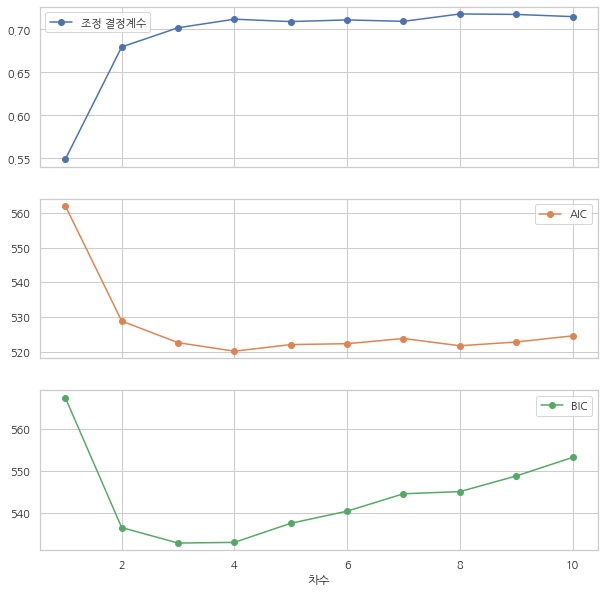

In [14]:
df_adj.plot(marker="o", subplots=True, figsize=(10, 10))
plt.show()

## 정규화

교차검증이 과최적화가 발생하는가를 알아내는 방법이라면 정규화(regularization)는 과최적화가 원천적으로 발생하지 못하게 하는 방법이다. 과최적화가 발생할 때는 선형회귀분석의 가중치의 크기가 비정상적으로 커지는 현상이 같이 발생한다. 정규화는 선형회귀분석 가중치의 크기가 너무 커지지 않도록 제어하여 과최적화가 발생하는 것을 막는다.

앞에서 수행한 다중회귀 결과에서 차수가 증가하면 가중치의 크기가 실제로 어떻게 변화하는지 살펴보자.

In [15]:
import numpy as np

w1 = {i: np.abs(r.params["scale(lstat)"]) for i, r in results.items()}
w2 = {i: np.abs(r.params["scale(I(lstat ** 2))"]) for i, r in results.items() if i > 1}
w3 = {i: np.abs(r.params["scale(I(lstat ** 3))"]) for i, r in results.items() if i > 2}
w4 = {i: np.abs(r.params["scale(I(lstat ** 4))"]) for i, r in results.items() if i > 3}
df_w = pd.DataFrame({"$|w_1|$": w1, "$|w_2|$": w2, "$|w_3|$": w3, "$|w_4|$": w4})
df_w.index.name = "차수"
df_w.style.bar()

,$|w_1|$,$|w_2|$,$|w_3|$,$|w_4|$
차수,,,,
1,4.387655,nan,nan,nan
2,11.705900,7.627214,nan,nan
3,20.997876,28.532474,12.307360,nan
4,37.561319,91.331808,97.520636,39.073867
5,32.970048,66.299925,41.693689,17.936717
6,4.345815,201.367311,796.591643,1371.376515
7,44.293542,571.215627,2357.648675,4999.339874
8,254.915344,2918.838627,14723.819307,42626.314789
9,430.317573,5183.139521,28939.241190,95943.395693


다항회귀 차수가 증가하면 가중치의 크기도 기하급수적으로 증가하는 것을 알 수 있다.

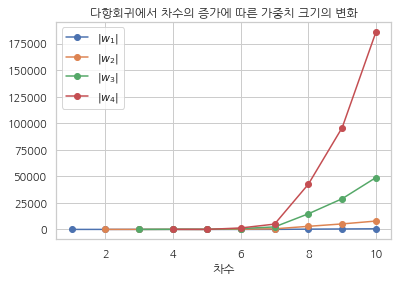

In [16]:
df_w.plot(marker="o", title="다항회귀에서 차수의 증가에 따른 가중치 크기의 변화")
plt.show()

정규화는 앞서 말한바와 같이 선형회귀분석 가중치의 크기가 너무 커지지 않도록 제어하여 과최적화가 발생하는 것을 막는 방법이다. 일반 선형회귀분석에서는 가중치를 구할 때 잔차제곱합 RSS를 최소화하는 가중치 벡터 $w$를 구했다. 

$$
w = \arg\min \Big( \text{RSS} \Big)
$$

하지만 정규화 선형회귀분석에서는 잔차제곱합 RSS에 가중치의 크기를 벌점(penality)으로 추가한 함수를 최소화한다.

$$ 
w = \arg\min \left( \dfrac{\text{RSS}}{2N} + \underbrace{\alpha \left( (1-L_1) \cdot \dfrac{1}{2}\sum_{k=1}^{K} w_k^2 + L_1 \cdot \sum_{k=1}^{K} |w_k| \right)}_{\text{벌점(penalty)}} \right)
$$

가중치의 크기를 측정하는 방법으로는 제곱합을 이용하는 L2 방법과 절대값의 합을 이용하는 L1 방법이 있는데 위의 수식은 두가지 방법을 동시에 사용한 것이다. L2 벌점만 사용할 때는 <b>Ridge 회귀</b>, L1 벌점만 사용할 때는 <b>Lasso 회귀</b>라고 하며 두가지를 동시에 사용할 때는 <b>Elastic-Net 회귀</b>라고 한다.

전체적인 벌점의 비중은 $\alpha$라는 값으로 조절한다. $\alpha$ 값을 크게 할수록 벌점이 커지므로 더 강력하게 정규화를 하는 것이다. L1 벌점과 L2 벌점의 상대적 비중은 $L_1$이라는 값으로 조절한다. L1=1 이면 L1 벌점만 사용하므로 Lasso 회귀가 되고 L1=0이면 L2 벌점만 사용하므로 Ridge 회귀가 된다. L1 값이 0과 1사이면 Elastic-Net 회귀다.

statsmodels 패키지에서 정규화 선형회귀를 하려면 모형 객체에서 `fit` 메서드가 아닌 `fit_regularized` 메서드를 호출한다. `fit_regularized` 메서드는 다음 두가지 인수를 가질 수 있다.

* `alpha` : 벌점 비중 $\alpha$
* `L1_wt` : L1 벌점 비중 $L_1$

In [17]:
formula = f"medv ~ scale({x_name})"
result1_reg = sm.OLS.from_formula(formula, boston_train).fit_regularized(alpha=0.1, L1_wt=0.5)

다만 `fit_regularized` 메서드로 나온 결과 객체는 일반 선형회귀분석 결과 객체처럼 다양한 기능이 없고 오로지 예측 기능을 위한 `predict` 메서드만 지원한다.

In [18]:
x = pd.DataFrame({x_name: np.linspace(0.1, 35.9, 100)})
y = result1_reg.predict(x)
y

0     28.973204
1     28.709802
2     28.446400
3     28.182999
4     27.919597
        ...    
95     3.950038
96     3.686636
97     3.423234
98     3.159832
99     2.896431
Length: 100, dtype: float64

정규화를 사용하여 1차부터 10차까지 다시 다항회귀를 한 결과는 다음과 같다. 일반 선형회귀와는 달리 차수를 증가시켜도 과최적화가 발생하지 않는 것을 볼 수 있다.

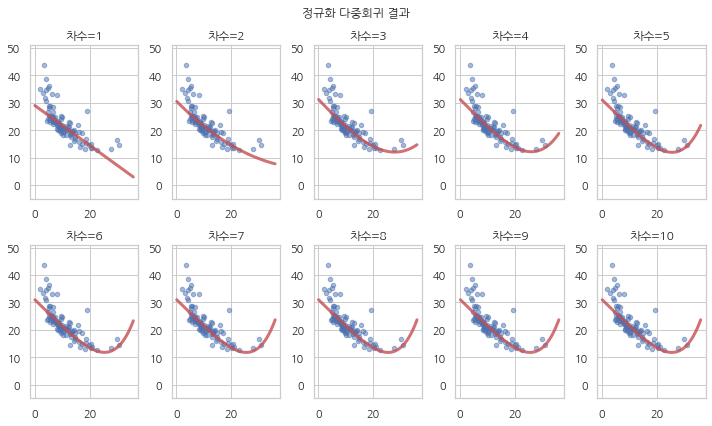

In [19]:
results_reg = {1: result1_reg}
for i in range(2, N + 1):
    formula += f" + scale(I({x_name} ** {i}))"
    result_reg_i = sm.OLS.from_formula(formula, boston_train).fit_regularized(alpha=0.1, L1_wt=0.5)
    results_reg[i] = result_reg_i


plt.figure(figsize=(10, 6))
for i in range(1, 11):
    plot_train(results_reg, i, [2, 5, i])
plt.suptitle("정규화 다중회귀 결과")
plt.tight_layout()
plt.show()